<a href="https://colab.research.google.com/github/argareeva/DataAnalyticsProject/blob/main/%D0%9E%D0%B1%D1%8A%D0%B5%D0%BC_%D0%BF%D0%BE%D0%B2%D0%B5%D1%80%D1%85%D0%BD%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.9 MB/s eta 0:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Прекурсор       10 non-null     int64  
 1   Растворитель    10 non-null     int64  
 2   t, C            10 non-null     int64  
 3   t, ч            10 non-null     int64  
 4   pH              10 non-null     float64
 5   HNO3            10 non-null     int64  
 6   CH3COOH         10 non-null     int64  
 7   HCl             10 non-null     int64  
 8   H2SO4           10 non-null     int64  
 9   Фазовый состав  10 non-null     int64  
 10  a(842), A       8 non-null      float64
 11  D(842), нм      8 non-null      float64
 12  SBET, м2/г      7 non-null      float64
 13  Vпор, см3/г     7 non-null      float64
dtypes: float64(5), int64(9)
memory usage: 1.2 KB
None
       Прекурсор  Растворитель        t, C       t, ч         pH       HNO3  \
count  10.000000     10.000000   10.000000  

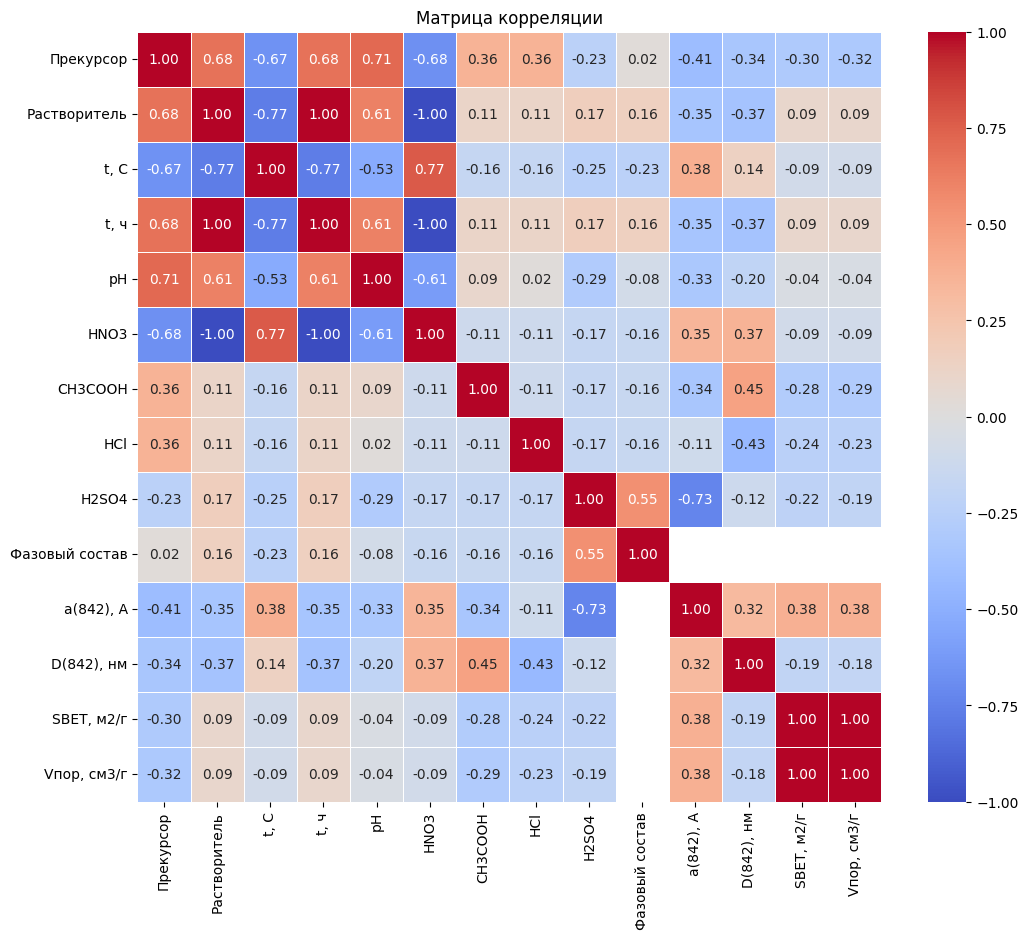

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Book.csv', delimiter=';')

data_numeric = data.drop(columns=['#', 't1, C', 'H1, Дж/г', 't2, C', 'H2, Дж/г', 'N, нм', 'Lk, мкм',
                                  'A1(C)', 'A2(C)', 'A1(O)', 'A2(O)', 'A1(Fe)', 'A2(Fe)', 'd1, нм', 'd2, нм','w1, %', 'w2, %'])

print(data_numeric.info())
print(data_numeric.describe())

correlation_matrix = data_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

1 вариант - линейная регрессия (хорошие метрики)

In [18]:
df_cleaned = data_numeric.dropna(subset=['Vпор, см3/г'])

df_cleaned.head(10)

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,Фазовый состав,"a(842), A","D(842), нм","SBET, м2/г","Vпор, см3/г"
0,11,21,150,8,1.5,31,0,0,0,41,72.76,33.4,1261.0,0.708
1,12,22,24,24,6.0,0,0,0,0,41,73.09,37.8,1827.4,1.001
2,12,22,24,24,5.0,0,0,0,0,41,72.48,21.3,6527.1,3.311
3,13,22,24,24,5.7,0,31,0,0,41,71.64,35.1,313.9,0.204
5,13,22,24,24,5.7,0,0,0,0,41,72.15,19.7,881.1,0.427
6,13,22,24,24,5.3,0,0,31,0,41,72.02,17.9,537.3,0.350
8,12,22,24,24,5.5,0,0,0,31,41,71.01,24.0,643.9,0.444


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_cleaned.drop(columns=['Vпор, см3/г', 'Растворитель', 't, C', 't, ч', 'HNO3', 'HCl', 'Фазовый состав'])
y = df_cleaned['Vпор, см3/г']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.4}')
print(f'MSE: {mse:.4}')
print(f'R^2: {r2:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': lr_model.coef_})
print(feature_weights)

MAE: 0.07867
MSE: 0.006436
R^2: 0.9092
      Feature    Weight
0   Прекурсор -0.000148
1          pH -0.000035
2     CH3COOH  0.001476
3       H2SO4  0.004256
4   a(842), A -0.000177
5  D(842), нм  0.001341
6  SBET, м2/г  0.000510


In [47]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(lr_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 0.3862


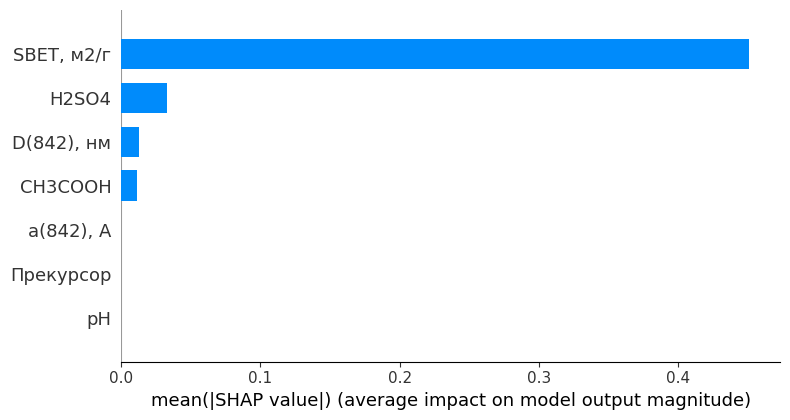

In [22]:
import shap

explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)
shap.summary_plot(explainer_lr.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)

2 вариант - xgboost

In [5]:
!pip install xgboost

In [27]:
df_cleaned = data.dropna(subset=['Vпор, см3/г'])

df_cleaned = df_cleaned.drop(columns=['Прекурсор', 'Растворитель', 'pH', 'Фазовый состав', 't, C', 't, ч', 'HNO3', 'CH3COOH', 'HCl', 'H2SO4', '#', 't1, C', 'H1, Дж/г', 't2, C', 'H2, Дж/г'])

df_cleaned.head(7)

,"a(842), A","D(842), нм","SBET, м2/г","Vпор, см3/г","N, нм","Lk, мкм",A1(C),A2(C),A1(O),A2(O),A1(Fe),A2(Fe),"d1, нм","d2, нм","w1, %","w2, %"
0,72.76,33.4,1261.0,0.708,350.0,5.0,70.21,69.70,25.92,26.97,3.85,3.25,9.7,25.9,86.06,13.94
1,73.09,37.8,1827.4,1.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.1,24.0,90.28,9.72
2,72.48,21.3,6527.1,3.311,300.0,10.0,68.00,66.57,21.47,27.95,10.51,5.46,9.9,25.3,96.49,3.51
3,71.64,35.1,313.9,0.204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,72.15,19.7,881.1,0.427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,72.02,17.9,537.3,0.350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,71.01,24.0,643.9,0.444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_cleaned.drop(columns=['Vпор, см3/г'])
y = df_cleaned['Vпор, см3/г']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

xgboost_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=5, subsample=1, random_state=42)
xgboost_model.fit(X_train, y_train)

xgboost_y_pred = xgboost_model.predict(X_test)
xgboost_mae = mean_absolute_error(y_test, xgboost_y_pred)
xgboost_mse = mean_squared_error(y_test, xgboost_y_pred)
xgboost_r2 = r2_score(y_test, xgboost_y_pred)

print(f'MAE (XGBoost): {xgboost_mae:.4}')
print(f'MSE (XGBoost): {xgboost_mse:.4}')
print(f'R^2 (XGBoost): {xgboost_r2:.4}')

MAE (XGBoost): 0.4376
MSE (XGBoost): 0.2811
R^2 (XGBoost): -2.966


In [48]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 1.391


3 вариант - xgboost на всех признаках

In [28]:
df_cleaned = data.drop(columns=['#'])
df_cleaned = df_cleaned.dropna(subset=['Vпор, см3/г'])

df_cleaned.head(7)

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,"t1, C",...,A1(C),A2(C),A1(O),A2(O),A1(Fe),A2(Fe),"d1, нм","d2, нм","w1, %","w2, %"
0,11,21,150,8,1.5,31,0,0,0,115.4,...,70.21,69.70,25.92,26.97,3.85,3.25,9.7,25.9,86.06,13.94
1,12,22,24,24,6.0,0,0,0,0,114.7,...,NaN,NaN,NaN,NaN,NaN,NaN,9.1,24.0,90.28,9.72
2,12,22,24,24,5.0,0,0,0,0,113.5,...,68.00,66.57,21.47,27.95,10.51,5.46,9.9,25.3,96.49,3.51
3,13,22,24,24,5.7,0,31,0,0,110.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,22,24,24,5.7,0,0,0,0,116.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,22,24,24,5.3,0,0,31,0,117.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12,22,24,24,5.5,0,0,0,31,115.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
from xgboost import XGBRegressor

X = df_cleaned.drop(columns=['Vпор, см3/г'])
y = df_cleaned['Vпор, см3/г']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

xgboost_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, gamma=0.5, learning_rate=0.001, max_depth=3, n_estimators=3, subsample=1, random_state=42)
xgboost_model.fit(X_train, y_train)

xgboost_y_pred = xgboost_model.predict(X_test)
xgboost_mae = mean_absolute_error(y_test, xgboost_y_pred)
xgboost_mse = mean_squared_error(y_test, xgboost_y_pred)
xgboost_r2 = r2_score(y_test, xgboost_y_pred)

print(f'MAE (XGBoost): {xgboost_mae:.4}')
print(f'MSE (XGBoost): {xgboost_mse:.4}')
print(f'R^2 (XGBoost): {xgboost_r2:.4}')

MAE (XGBoost): 0.4118
MSE (XGBoost): 0.2415
R^2 (XGBoost): -2.408


In [55]:
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 1.259


3 вариант - decision tree (плохие метрики)

In [38]:
df_cleaned = data_numeric.dropna(subset=['Vпор, см3/г'])

df_cleaned.head(10)

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,Фазовый состав,"a(842), A","D(842), нм","SBET, м2/г","Vпор, см3/г"
0,11,21,150,8,1.5,31,0,0,0,41,72.76,33.4,1261.0,0.708
1,12,22,24,24,6.0,0,0,0,0,41,73.09,37.8,1827.4,1.001
2,12,22,24,24,5.0,0,0,0,0,41,72.48,21.3,6527.1,3.311
3,13,22,24,24,5.7,0,31,0,0,41,71.64,35.1,313.9,0.204
5,13,22,24,24,5.7,0,0,0,0,41,72.15,19.7,881.1,0.427
6,13,22,24,24,5.3,0,0,31,0,41,72.02,17.9,537.3,0.350
8,12,22,24,24,5.5,0,0,0,31,41,71.01,24.0,643.9,0.444


In [56]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor

X = df_cleaned.drop(columns=['Vпор, см3/г'])
y = df_cleaned['Vпор, см3/г']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_dt.best_params_)

cv_scores = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print(f"Среднее значение MSE на кросс-валидации: {-cv_scores.mean():.4}")

y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'MAE (Decision Tree): {mae_dt:.4}')
print(f'MSE (Decision Tree): {mse_dt:.4}')
print(f'R^2 (Decision Tree): {r2_dt:.4}')

Оптимальные параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Среднее значение MSE на кросс-валидации: 4.138
MAE (Decision Tree): 0.6505
MSE (Decision Tree): 0.4446
R^2 (Decision Tree): -19.72


In [57]:
dt_model_tuned = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=7, random_state=42)
dt_model_tuned.fit(X_train, y_train)

y_pred_dt_tuned = dt_model_tuned.predict(X_test)

mae_dt_tuned = mean_absolute_error(y_test, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned)
r2_dt_tuned = r2_score(y_test, y_pred_dt_tuned)

print(f'MAE (Tuned Decision Tree): {mae_dt_tuned:.4}')
print(f'MSE (Tuned Decision Tree): {mse_dt_tuned:.4}')
print(f'R^2 (Tuned Decision Tree): {r2_dt_tuned:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': dt_model_tuned.feature_importances_})
print(feature_weights)

MAE (Tuned Decision Tree): 0.1465
MSE (Tuned Decision Tree): 0.03006
R^2 (Tuned Decision Tree): -0.4004
           Feature  Weight
0        Прекурсор     0.0
1     Растворитель     0.0
2             t, C     0.0
3             t, ч     0.0
4               pH     0.0
5             HNO3     0.0
6          CH3COOH     0.0
7              HCl     0.0
8            H2SO4     0.0
9   Фазовый состав     0.0
10       a(842), A     0.0
11      D(842), нм     0.0
12      SBET, м2/г     0.0


4 вариант - рандом форест (плохие метрики)

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf_model, param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_rf.best_params_)

y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'MAE (Random Forest): {mae_rf:.4}')
print(f'MSE (Random Forest): {mse_rf:.4}')
print(f'R^2 (Random Forest): {r2_rf:.4}')

Оптимальные параметры: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE (Random Forest): 0.5773
MSE (Random Forest): 0.5673
R^2 (Random Forest): -25.43


In [60]:
from sklearn.ensemble import RandomForestRegressor

rf_model_tuned = RandomForestRegressor(n_estimators=10, max_depth=10, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_model_tuned.fit(X_train, y_train)

y_pred_rf_tuned = rf_model_tuned.predict(X_test)

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f'MAE (Tuned Random Forest): {mae_rf_tuned:.4}')
print(f'MSE (Tuned Random Forest): {mse_rf_tuned:.4}')
print(f'R^2 (Tuned Random Forest): {r2_rf_tuned:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': rf_model_tuned.feature_importances_})
print(feature_weights)

MAE (Tuned Random Forest): 0.2907
MSE (Tuned Random Forest): 0.1567
R^2 (Tuned Random Forest): -6.299
           Feature    Weight
0        Прекурсор  0.202473
1     Растворитель  0.000000
2             t, C  0.000000
3             t, ч  0.000000
4               pH  0.100001
5             HNO3  0.000000
6          CH3COOH  0.100394
7              HCl  0.097045
8            H2SO4  0.000000
9   Фазовый состав  0.000000
10       a(842), A  0.000372
11      D(842), нм  0.000056
12      SBET, м2/г  0.499659
